<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_TL1_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Transfer Learning Feature Extraction

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import zipfile
import os
import pathlib
import random

import datetime

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Setup

In [ ]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-darkgrid')

### Constantes

In [ ]:
SEED = 2008193

DIR_TREINO = '10_food_classes_10_percent/train'
DIR_TESTE = '10_food_classes_10_percent/test'

DIR_TREINO_COMPLETO = '10_food_classes_all_data/train'

BATCH_SIZE = 32
IMAGE_SHAPE = (224, 224)
CLASS_MODE = 'categorical'

INPUT_SHAPE = IMAGE_SHAPE + (3,)
ACTIVATION = 'softmax'

PERDA = 'categorical_crossentropy'
OTIMIZADOR = Adam()
METRICAS = ['accuracy']

### Funções

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
# Função para criar callback TensorBoard
def criar_callback_tensorboard(diretorio, experimento):
    # Diretório do TensorBoard
    dir_log = diretorio + '/' + experimento + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    
    # Criando o callback
    cb_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=dir_log)

    print(f"Salvando log TensorBoard em: '{dir_log}'.")

    return cb_tensorboard

In [ ]:
def criar_modelo(modelo_url, quantidade_classes):
    """
    Cria um modelo sequencial Keras.

    Args:
        modelo_url (str): URL do modelo no TensorFlow Hub
        quantidade_classes (int): Quantidade de neurônios na camada de saída (classes).
    
    Returns:
        Um modelo sequencial Keras não-compilado, criado com os argumentos informados.
    """

    modelo = Sequential()

    modelo.add(hub.KerasLayer(handle=modelo_url,
                              trainable=False, # mantém os padrões aprendidos
                              input_shape=INPUT_SHAPE))

    modelo.add(Dense(quantidade_classes, activation=ACTIVATION))

    return modelo

In [ ]:
def grafico_perda_precisao_por_iteracao(historico):
    sns.lineplot(data=historico.history['loss'], label='Perda no treinamento')
    sns.lineplot(data=historico.history['accuracy'], label='Precisão no treinamento')

    if historico.history['val_loss']:
        sns.lineplot(data=historico.history['val_loss'], label='Perda na validação')
        sns.lineplot(data=historico.history['val_accuracy'], label='Precisão na validação')

    plt.title('Histórico de perda e precisão por iteração')
    plt.xlabel('Iteração')
    plt.ylabel('Perda / Precisão')

    plt.legend(frameon=True, facecolor='white')
    plt.show()

In [ ]:
# Create a function to import and image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
    """
    Reads an image from filename, turns it into a tensor and reshapes it 
    to (img_shape, img_shape, colour_channels).
    """

    # Read in the image
    img = tf.io.read_file(filename)

    # Decode the read file into a tensor
    img = tf.image.decode_image(img)

    # Resize the image
    img = tf.image.resize(img, size=[img_shape, img_shape])

    # Rescale the image (get all values between 0 and 1)
    img = img/255.

    return img

def pred_and_plot(model, filename, class_names):
    """
    Imports an image located at filename, makes a prediction with model
    and plots the image with the predicted class as the title.
    """

    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Get the predicted class
    if len(pred[0]) > 1: # Multi-class
        pred_class = class_names[pred.argmax()]
        pred_perc = pred.max()
    else: # Binary
        pred_class = class_names[int(tf.round(pred))]
        pred_perc = tf.squeeze(pred if pred >= 0.5 else 1 - pred)

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class} ({(pred_perc * 100):0.2f}%)")
    plt.axis(False)
    plt.show()

## Dados iniciais (10% da base de treino Food 101, toda a base de teste.)

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_tl = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_tl.extractall()
zip_tl.close()

--2023-01-21 14:43:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 142.250.145.128, 2a00:1450:4013:c07::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  39.1MB/s    in 4.7s    

2023-01-21 14:44:04 (34.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



### Verificando os dados

In [ ]:
# for caminho, diretorios, arquivos in os.walk('10_food_classes_10_percent'):
#     print(f"Há {len(diretorios)} diretórios e {len(arquivos)} imagens em '{caminho}'.")

In [ ]:
diretorio = pathlib.Path(DIR_TREINO)
rotulos = np.array(sorted([item.name for item in diretorio.glob('*')]))

# rotulos

## Pré-processamento dos dados

### Importando dados e tranformando em lotes

In [ ]:
dg_treino = ImageDataGenerator(rescale=1./255)
dg_teste = ImageDataGenerator(rescale=1./255)

dados_treino = dg_treino.flow_from_directory(directory=DIR_TREINO,
                                             batch_size=BATCH_SIZE,
                                             target_size=IMAGE_SHAPE,
                                             class_mode=CLASS_MODE,
                                             seed=SEED)

dados_teste = dg_teste.flow_from_directory(directory=DIR_TESTE,
                                           batch_size=BATCH_SIZE,
                                           target_size=IMAGE_SHAPE,
                                           class_mode=CLASS_MODE,
                                           seed=SEED)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Criando modelos usando TensorFlow Hub

Modelos pré-treinados podem ser encontrados em: https://tfhub.dev/

### https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector

In [ ]:
# enfv = criar_modelo(modelo_url='https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1',
#                     quantidade_classes=len(rotulos))

# enfv.compile(loss=PERDA,
#              optimizer=OTIMIZADOR,
#              metrics=METRICAS)

# hist_enfv = enfv.fit(dados_treino,
#                      epochs=5,
#                      steps_per_epoch=len(dados_treino),
#                      validation_data=dados_teste,
#                      validation_steps=len(dados_teste),
#                      callbacks=[criar_callback_tensorboard(diretorio='feature_vector',
#                                                            experimento='enfv')],
#                      verbose=1)

In [ ]:
# grafico_perda_precisao_por_iteracao(hist_enfv)

### https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector

In [ ]:
# rnfv = criar_modelo(modelo_url='https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5',
#                     quantidade_classes=len(rotulos))

# rnfv.compile(loss=PERDA,
#              optimizer=OTIMIZADOR,
#              metrics=METRICAS)

# hist_rnfv = rnfv.fit(dados_treino,
#                      epochs=5,
#                      steps_per_epoch=len(dados_treino),
#                      validation_data=dados_teste,
#                      validation_steps=len(dados_teste),
#                      callbacks=[criar_callback_tensorboard(diretorio='feature_vector',
#                                                            experimento='rnfv')],
#                      verbose=1)

In [ ]:
# grafico_perda_precisao_por_iteracao(hist_rnfv)

## Expandindo dados e aperfeiçoando modelos

In [ ]:
dg_treino_expandido = ImageDataGenerator(rescale=1./255,
                                         rotation_range=0.2,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True)

dados_treino_expandidos = dg_treino_expandido.flow_from_directory(directory=DIR_TREINO,
                                                                  batch_size=BATCH_SIZE,
                                                                  target_size=IMAGE_SHAPE,
                                                                  class_mode=CLASS_MODE,
                                                                  seed=SEED)

Found 750 images belonging to 10 classes.


In [ ]:
# enfve = criar_modelo(modelo_url='https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1',
#                      quantidade_classes=len(rotulos))

# enfve.compile(loss=PERDA,
#               optimizer=OTIMIZADOR,
#               metrics=METRICAS)

# hist_enfve = enfve.fit(dados_treino_expandidos,
#                        epochs=5,
#                        steps_per_epoch=len(dados_treino_expandidos),
#                        validation_data=dados_teste,
#                        validation_steps=len(dados_teste),
#                        callbacks=[criar_callback_tensorboard(diretorio='feature_vector',
#                                                              experimento='enfv_expandido')],
#                        verbose=1)

Salvando log TensorBoard em: 'feature_vector/enfv_expandido/20230121-144954'.
Epoch 1/5
24/24 [==============================] - 39s 1s/step - loss: 1.9168 - accuracy: 0.3987 - val_loss: 1.3532 - val_accuracy: 0.7136
Epoch 2/5
24/24 [==============================] - 23s 991ms/step - loss: 1.1653 - accuracy: 0.7413 - val_loss: 0.9047 - val_accuracy: 0.8116
Epoch 3/5
24/24 [==============================] - 22s 943ms/step - loss: 0.8566 - accuracy: 0.8040 - val_loss: 0.7218 - val_accuracy: 0.8392
Epoch 4/5
24/24 [==============================] - 22s 934ms/step - loss: 0.7159 - accuracy: 0.8253 - val_loss: 0.6302 - val_accuracy: 0.8528
Epoch 5/5
24/24 [==============================] - 31s 1s/step - loss: 0.6053 - accuracy: 0.8667 - val_loss: 0.5696 - val_accuracy: 0.8620


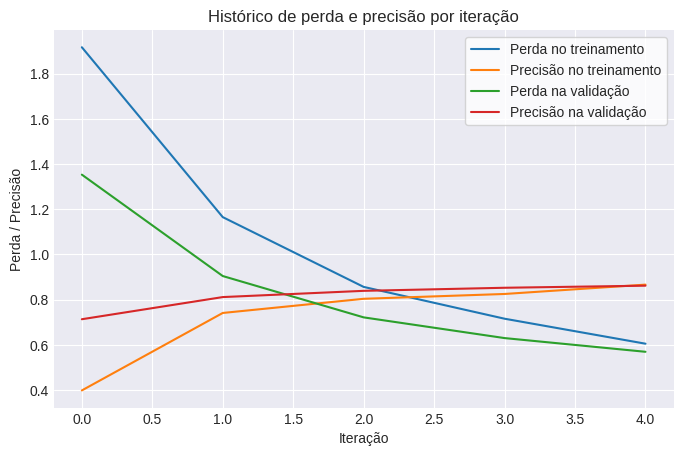

In [ ]:
# grafico_perda_precisao_por_iteracao(hist_enfve)

## Modelando com base de treino completa

In [ ]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# zip_fc = zipfile.ZipFile('10_food_classes_all_data.zip')
# zip_fc.extractall()
# zip_fc.close()

dg_treino_completo_expandido = ImageDataGenerator(rescale=1./255,
                                                  rotation_range=0.2,
                                                  shear_range=0.2,
                                                  zoom_range=0.2,
                                                  horizontal_flip=True)

dados_treino_completo_expandidos = dg_treino_completo_expandido.flow_from_directory(directory=DIR_TREINO_COMPLETO,
                                                                                    batch_size=BATCH_SIZE,
                                                                                    target_size=IMAGE_SHAPE,
                                                                                    class_mode=CLASS_MODE,
                                                                                    seed=SEED)

--2023-01-21 15:10:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 108.177.127.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  37.7MB/s    in 15s     

2023-01-21 15:10:26 (32.9 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]

Found 7500 images belonging to 10 classes.


In [ ]:
# enfvc = criar_modelo(modelo_url='https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1',
#                      quantidade_classes=len(rotulos))

# enfvc.compile(loss=PERDA,
#               optimizer=OTIMIZADOR,
#               metrics=METRICAS)

# hist_enfvc = enfvc.fit(dados_treino_completo_expandidos,
#                        epochs=10,
#                        steps_per_epoch=len(dados_treino_completo_expandidos),
#                        validation_data=dados_teste,
#                        validation_steps=len(dados_teste),
#                        callbacks=[criar_callback_tensorboard(diretorio='feature_vector',
#                                                              experimento='enfv_completo')],
#                        verbose=1)

Salvando log TensorBoard em: 'feature_vector/enfv_completo/20230121-151749'.
Epoch 1/10
235/235 [==============================] - 131s 523ms/step - loss: 0.8821 - accuracy: 0.7455 - val_loss: 0.4160 - val_accuracy: 0.8844
Epoch 2/10
235/235 [==============================] - 121s 515ms/step - loss: 0.5087 - accuracy: 0.8445 - val_loss: 0.3382 - val_accuracy: 0.9004
Epoch 3/10
235/235 [==============================] - 115s 488ms/step - loss: 0.4282 - accuracy: 0.8700 - val_loss: 0.3112 - val_accuracy: 0.9028
Epoch 4/10
235/235 [==============================] - 123s 522ms/step - loss: 0.3921 - accuracy: 0.8780 - val_loss: 0.2984 - val_accuracy: 0.9064
Epoch 5/10
235/235 [==============================] - 115s 489ms/step - loss: 0.3632 - accuracy: 0.8847 - val_loss: 0.2989 - val_accuracy: 0.9024
Epoch 6/10
235/235 [==============================] - 113s 483ms/step - loss: 0.3383 - accuracy: 0.8967 - val_loss: 0.2810 - val_accuracy: 0.9076
Epoch 7/10
235/235 [===========================

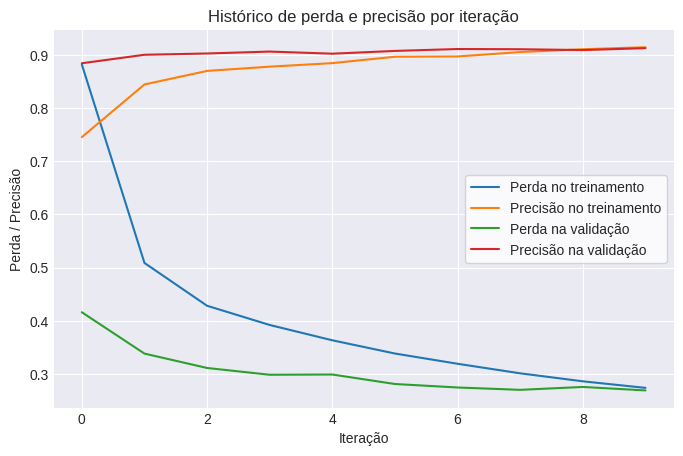

In [ ]:
# grafico_perda_precisao_por_iteracao(hist_enfvc)

In [ ]:
# rnfvc = criar_modelo(modelo_url='https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5',
#                      quantidade_classes=len(rotulos))

# rnfvc.compile(loss=PERDA,
#               optimizer=OTIMIZADOR,
#               metrics=METRICAS)

# hist_rnfvc = rnfvc.fit(dados_treino_completo_expandidos,
#                        epochs=10,
#                        steps_per_epoch=len(dados_treino_completo_expandidos),
#                        validation_data=dados_teste,
#                        validation_steps=len(dados_teste),
#                        callbacks=[criar_callback_tensorboard(diretorio='feature_vector',
#                                                              experimento='rnfv_completo')],
#                        verbose=1)

Salvando log TensorBoard em: 'feature_vector/rnfv_completo/20230121-154210'.
Epoch 1/10
235/235 [==============================] - 124s 509ms/step - loss: 0.9492 - accuracy: 0.7229 - val_loss: 0.5159 - val_accuracy: 0.8252
Epoch 2/10
235/235 [==============================] - 117s 499ms/step - loss: 0.5697 - accuracy: 0.8127 - val_loss: 0.5631 - val_accuracy: 0.8152
Epoch 3/10
235/235 [==============================] - 118s 502ms/step - loss: 0.4849 - accuracy: 0.8392 - val_loss: 0.4814 - val_accuracy: 0.8412
Epoch 4/10
235/235 [==============================] - 118s 500ms/step - loss: 0.4317 - accuracy: 0.8561 - val_loss: 0.4756 - val_accuracy: 0.8460
Epoch 5/10
235/235 [==============================] - 117s 497ms/step - loss: 0.4138 - accuracy: 0.8613 - val_loss: 0.4620 - val_accuracy: 0.8456
Epoch 6/10
235/235 [==============================] - 117s 499ms/step - loss: 0.3766 - accuracy: 0.8701 - val_loss: 0.4608 - val_accuracy: 0.8492
Epoch 7/10
235/235 [===========================

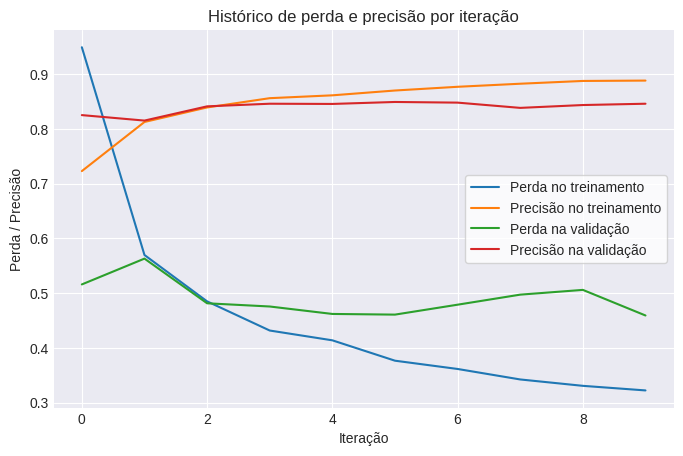

In [ ]:
# grafico_perda_precisao_por_iteracao(hist_rnfvc)

## Salvando modelos

In [ ]:
# Formato HDF5
# enfve.save('modelo_enfve_HDF5.h5')
# enfvc.save('modelo_enfvc_HDF5.h5')
# rnfvc.save('modelo_rnfvc_HDF5.h5')

## Carregando modelos

In [ ]:
enfvc = tf.keras.models.load_model('modelo_enfvc_HDF5.h5')
rnfvc = tf.keras.models.load_model('modelo_rnfvc_HDF5.h5')

# rotulos = np.array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'])

## Testando modelos

In [ ]:
novos_dados = ['https://www.alegretetudo.com.br/wp-content/uploads/2022/12/alegretetudo-piero-pizza-napoletana-uma-referencia-na-gastronomia-alegretense-piero-1.jpg',
               'https://www.thedailymeal.com/img/gallery/the-best-flour-choice-for-a-homemade-neapolitan-pizza/l-intro-1673454821.jpg',
               'https://doordash-static.s3.amazonaws.com/media/store/header/e677ff3e-fe3e-4478-839d-543ce9f9f832.jpg',
               'https://natashaskitchen.com/wp-content/uploads/2020/03/Pan-Seared-Steak-4.jpg',
               'https://img.hellofresh.com/f_auto,fl_lossy,q_auto,w_1200/hellofresh_s3/image/6243263a18a51738954a3a82-044a399e.jpg',
               'https://whitneybond.com/wp-content/uploads/2021/06/steak-marinade-13.jpg',
               'https://www.cookingclassy.com/wp-content/uploads/2018/08/chicken-curry-11.jpg',
               'https://www.licious.in/blog/wp-content/uploads/2020/12/Chicken-Curry-recipe.jpg',
               'https://savvybites.co.uk/wp-content/uploads/2020/10/Coconut-Chicken-Curry-4-of-5.jpg',
               'https://www.seriouseats.com/thmb/zNzv_FjRF4hEbpawVKJDC-JU0g8=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/the-best-buffalo-wings-oven-fried-wings-recipe-hero-dcc412b6e26444b4a2112d4402f039ae.JPG',
               'https://mccormick.widen.net/content/n0phdkxdlp/jpeg/Franks_RedHot_Buffalo_Chicken_Wings.jpg',
               'https://www.foodandwine.com/thmb/YqtSpajmztyHG1tWz3VlGj6MT_o=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/Buffalo-Wings-Recipe-FT-BLOG1222-26e07fdb9aec4afe8d4bc39ea331c753.jpg',
               'https://www.allrecipes.com/thmb/WAaJX7ghFAiGjU3WGRmRC424exA=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/6751001-egg-fried-rice-Mariya-Tkachenko-4x3-1-0a5504e18cea49c2bf4419799bd50ad9.jpg',
               'https://www.indianhealthyrecipes.com/wp-content/uploads/2020/12/fried-rice.jpg',
               'https://images.squarespace-cdn.com/content/v1/5ed666a6924cd0017d343b01/1593466464958-HD61RC4NOR0G4Q6FIP7W/bite-me-more-apple-vegetable-fried-rice-recipe.jpg',
               'https://www.acouplecooks.com/wp-content/uploads/2020/05/Grilled-Salmon-015-1.jpg',
               'https://hips.hearstapps.com/hmg-prod/images/how-to-grill-salmon-recipe1-1655870645.jpg',
               'https://images-gmi-pmc.edge-generalmills.com/7f4554ba-8c3b-483f-ab26-7e2235343c73.jpg',
               'https://assets.epicurious.com/photos/57c5c6d9cf9e9ad43de2d96e/1:1/w_2560%2Cc_limit/the-ultimate-hamburger.jpg',
               'https://assets.biggreenegg.eu/app/uploads/2019/03/28145521/topimage-classic-hamburger-2019m04-800x534-600x401.jpg',
               'https://www.thecountrycook.net/wp-content/uploads/2011/03/thumbnail-Homemade-Freddys-Steakburger-Cheeseburgers-scaled.jpg',
               'https://upload.wikimedia.org/wikipedia/commons/d/da/Strawberry_ice_cream_cone_%285076899310%29.jpg',
               'https://img.etimg.com/thumb/width-1200,height-900,imgsize-381352,resizemode-1,msid-84939728/magazines/panache/from-the-us-russia-to-india-an-ice-cream-bowl-has-a-long-political-history.jpg',
               'https://i.pinimg.com/originals/97/15/62/971562a8ea05473cb1d3daa5e4b85b6d.jpg',
               'https://www.pacificfoods.com/wp-content/uploads/2022/08/SP_Recipes_0002_Ramen.jpg',
               'https://hips.hearstapps.com/hmg-prod/images/190208-delish-ramen-horizontal-093-1550096715.jpg',
               'https://i0.wp.com/seonkyounglongest.com/wp-content/uploads/2018/04/shoyu-ramen-1.jpg',
               'https://t1.uc.ltmcdn.com/pt/posts/2/0/3/como_fazer_sushi_delicioso_10302_orig.jpg',
               'https://xtudoreceitas.com/wp-content/uploads/Sushi.jpg',
               'https://cdn.britannica.com/52/128652-050-14AD19CA/Maki-zushi.jpg']

In [ ]:
# for nd in novos_dados:
#     !wget '{nd}' -O nova_imagem.jpg
#     pred_and_plot(enfvc, 'nova_imagem.jpg', rotulos)

In [ ]:
# for nd in novos_dados:
#     !wget '{nd}' -O nova_imagem.jpg
#     pred_and_plot(rnfvc, 'nova_imagem.jpg', rotulos)

In [ ]:
!wget '{random.choice(novos_dados)}' -O nova_imagem.jpg
pred_and_plot(enfvc, 'nova_imagem.jpg', rotulos)

## Comparando modelos utilizando TensorBoard

**ATENÇÃO:** Dados enviados ao TensorBoard dev ficarão **PÚBLICOS**.

In [ ]:
# # Enviar resultados ao TensorBoard dev

# !tensorboard dev upload --logdir ./feature_vector/ \
#                         --name "EfficientNetB0 vs ResNet50V2 - Primeiros testes" \
#                         --description "Testes iniciais comparando dois modelos do TFHub utilizando a base Food101." \
#                         --one_shot

TensorBoard link: https://tensorboard.dev/experiment/1omB24r1SJWzJtpkGli57g/

In [ ]:
# # Lista de experimentos enviados

# !tensorboard dev list

https://tensorboard.dev/experiment/1omB24r1SJWzJtpkGli57g/
	Name                 EfficientNetB0 vs ResNet50V2 - Primeiros testes
	Description          Testes iniciais comparando dois modelos do TFHub utilizando a base Food101.
	Id                   1omB24r1SJWzJtpkGli57g
	Created              2023-01-21 16:48:08 (11 minutes ago)
	Updated              2023-01-21 16:48:13 (11 minutes ago)
	Runs                 6
	Tags                 5
	Scalars              150
	Tensor bytes         0
	Binary object bytes  9821247
Total: 1 experiment(s)


In [ ]:
# # Excluir experimento do TensorBoard

# !tensorboard dev delete --experiment_id blablablablablabla